# Predictive Analysis: Model Development

## Predict Hourly Rented Bike Count using Basic Linear Regression Models

## Import the datatset

`tidymodels` is used to build baseline linear regression models to predict the hourly rented bike count using related weather and date information.

- Split data into training and testing datasets.
- Build a linear regression model using only the weather variables.
- Build a linear regression model using both weather and date variables.
- Evaluate the models and identify important variables.

Install and import the necessary libraries.


In [1]:
# install.packages("rlang")
# install.packages("tidymodels")

In [2]:
library("tidymodels")
library("tidyverse")
library("stringr")

-- Attaching packages -------------------------------------- tidymodels 1.0.0 --

v broom        1.0.3     v recipes      1.0.5
v dials        1.1.0     v rsample      1.1.1
v dplyr        1.1.0     v tibble       3.1.8
v ggplot2      3.4.0     v tidyr        1.3.0
v infer        1.0.4     v tune         1.0.1
v modeldata    1.1.0     v workflows    1.1.3
v parsnip      1.0.4     v workflowsets 1.0.0
v purrr        1.0.1     v yardstick    1.1.0

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x purrr::discard() masks scales::discard()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
x recipes::step()  masks stats::step()
* Use suppressPackageStartupMessages() to eliminate package startup messages

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v readr   2.1.3     v forcats 1.0.0
v stringr 1.5.0     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x readr::c

The `seoul_bike_sharing_converted_normalized.csv` is the main dataset used. It has the following variables:

The response variable:
- `RENTED BIKE COUNT`: Count of bikes rented at each hour

Weather predictor variables:
- `TEMPERATURE`: Temperature in Celsius
- `HUMIDITY`: `%`
- `WIND_SPEED`: `m/s`
- `VISIBILITY`: Multiplied by 10m
- `DEW_POINT_TEMPERATURE`: The temperature (Celsius) at which humidity reaches saturation and below which, precipitation is likely.
- `SOLAR_RADIATION`: MJ/m2
- `RAINFALL`: mm
- `SNOWFALL`: cm

Date/time predictor variables:
- `DATE`: Year-month-day
- `HOUR`: Hour of the day
- `FUNCTIONAL DAY`: `Yes` (Functional hours), `No` (Non Functional Hours)
- `HOLIDAY` - Holiday/No holiday
- `SEASONS` - Winter, Spring, Summer, Autumn

Download and review the dataset provided at:\
https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/datasets/seoul_bike_sharing_converted_normalized.csv

In [3]:
dataset_url <- "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/datasets/seoul_bike_sharing_converted_normalized.csv"
bike_sharing_df <- read_csv(dataset_url)
spec(bike_sharing_df)

Rows: 8465 Columns: 41
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): DATE, FUNCTIONING_DAY
dbl (39): RENTED_BIKE_COUNT, TEMPERATURE, HUMIDITY, WIND_SPEED, VISIBILITY, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


cols(
  DATE = col_character(),
  RENTED_BIKE_COUNT = col_double(),
  TEMPERATURE = col_double(),
  HUMIDITY = col_double(),
  WIND_SPEED = col_double(),
  VISIBILITY = col_double(),
  DEW_POINT_TEMPERATURE = col_double(),
  SOLAR_RADIATION = col_double(),
  RAINFALL = col_double(),
  SNOWFALL = col_double(),
  FUNCTIONING_DAY = col_character(),
  `0` = col_double(),
  `1` = col_double(),
  `10` = col_double(),
  `11` = col_double(),
  `12` = col_double(),
  `13` = col_double(),
  `14` = col_double(),
  `15` = col_double(),
  `16` = col_double(),
  `17` = col_double(),
  `18` = col_double(),
  `19` = col_double(),
  `2` = col_double(),
  `20` = col_double(),
  `21` = col_double(),
  `22` = col_double(),
  `23` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double(),
  `8` = col_double(),
  `9` = col_double(),
  AUTUMN = col_double(),
  SPRING = col_double(),
  SUMMER = col_double(),
  WINTER = col_double(),
  HOLIDAY 

For this model, the `DATE` column is dropped as it essentially acts as an index. (NB There is scope to use the `DATE` column to create a `day_of_week` or `isWeekend` column, which might demonstrate an affect on preferred bike rental times.)\
`FUNCTIONAL DAY` is dropped as it has only one distinct value (`YES`) remaining following missing value removal.

In [4]:
bike_sharing_df <- bike_sharing_df %>% 
                   select(-DATE, -FUNCTIONING_DAY)

## Split training and testing data

The dataset is split into training and testing datasets.

The training dataset will be used for fitting regression models, while the testing dataset will be used to evaluate the trained models.

The `initial_split()`, `training()`, and `testing()` functions are used to generate a training dataset consisting of 75% of the original dataset, and a testing dataset using the remaining 25%.\
A defined random number seed is used to generate consistent results during development.

In [5]:
# Use the `initial_split()`, `training()`, and `testing()` functions to split the dataset
# With seed 1234
set.seed(1234)

# prop = 3/4 (training dataset proportion)
bike_sharing_split <- initial_split(bike_sharing_df, prop=3/4)

# train_data 
train_data <-training(bike_sharing_split)

# test_data
test_data <-testing(bike_sharing_split)

## Linear regression model using only weather variables

Weather conditions likely affect people's bike renting decisions, e.g. a preference for alternative modes of transportation in adverse weather vs a preference for bike rentals on nice and sunny days.

A linear regression model called `lm_model_weather` is built, using the following weather variables:

- `TEMPERATURE`
- `HUMIDITY`
- `WIND_SPEED`
- `VISIBILITY`
- `DEW_POINT_TEMPERATURE`
- `SOLAR_RADIATION`
- `RAINFALL`
- `SNOWFALL`

Define a linear regression model specification.


In [6]:
# Use `linear_reg()` with engine `lm` and mode `regression`
lm_spec <- linear_reg() %>%
    set_engine(engine="lm") %>%
    set_mode("regression")
lm_spec

Linear Regression Model Specification (regression)

Computational engine: lm 


Fit a model with the response variable `RENTED_BIKE_COUNT` and predictor variables `TEMPERATURE + HUMIDITY + WIND_SPEED + VISIBILITY + DEW_POINT_TEMPERATURE + SOLAR_RADIATION + RAINFALL + SNOWFALL`


In [7]:
# Fit the model called `lm_model_weather`
# RENTED_BIKE_COUNT ~ TEMPERATURE + HUMIDITY + WIND_SPEED + VISIBILITY + DEW_POINT_TEMPERATURE + SOLAR_RADIATION + RAINFALL + SNOWFALL,  with the training data
lm_model_weather<- lm_spec %>%
    fit(RENTED_BIKE_COUNT ~ TEMPERATURE + HUMIDITY + WIND_SPEED + VISIBILITY +
        DEW_POINT_TEMPERATURE + SOLAR_RADIATION + RAINFALL + SNOWFALL, data=train_data)     

Print the fit summary for the `lm_model_weather` model.


In [8]:
print(lm_model_weather$fit)


Call:
stats::lm(formula = RENTED_BIKE_COUNT ~ TEMPERATURE + HUMIDITY + 
    WIND_SPEED + VISIBILITY + DEW_POINT_TEMPERATURE + SOLAR_RADIATION + 
    RAINFALL + SNOWFALL, data = data)

Coefficients:
          (Intercept)            TEMPERATURE               HUMIDITY  
               156.71                2399.74                -918.38  
           WIND_SPEED             VISIBILITY  DEW_POINT_TEMPERATURE  
               404.47                  12.56                -316.92  
      SOLAR_RADIATION               RAINFALL               SNOWFALL  
              -444.85               -1764.01                 317.78  



Review the model details such as formula, residuals, and coefficients.

In [9]:
summary(lm_model_weather$fit)


Call:
stats::lm(formula = RENTED_BIKE_COUNT ~ TEMPERATURE + HUMIDITY + 
    WIND_SPEED + VISIBILITY + DEW_POINT_TEMPERATURE + SOLAR_RADIATION + 
    RAINFALL + SNOWFALL, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1348.46  -294.03   -57.28   208.59  2329.78 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)             156.71      58.07   2.699  0.00698 ** 
TEMPERATURE            2399.74     261.66   9.171  < 2e-16 ***
HUMIDITY               -918.38     126.79  -7.243  4.9e-13 ***
WIND_SPEED              404.47      48.16   8.399  < 2e-16 ***
VISIBILITY               12.56      24.86   0.505  0.61351    
DEW_POINT_TEMPERATURE  -316.92     278.83  -1.137  0.25575    
SOLAR_RADIATION        -444.85      34.69 -12.824  < 2e-16 ***
RAINFALL              -1764.01     182.65  -9.658  < 2e-16 ***
SNOWFALL                317.78     131.58   2.415  0.01576 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


## Linear regression model using all variables

In addition to weather, other factors may affect bike rental demand, such as the time of a day, holiday, etc.

A linear regression model called `lm_model_all` is built using all (weather and fate/time) variables, using `RENTED_BIKE_COUNT ~ .`

In [10]:
# Fit the model called `lm_model_all`
# `RENTED_BIKE_COUNT ~ .` means use all other variables except for the response variable
lm_model_all<- lm_spec %>%
    fit(RENTED_BIKE_COUNT ~ ., data=train_data)

Print the fit summary for `lm_model_all`.


In [11]:
print(lm_model_all$fit)


Call:
stats::lm(formula = RENTED_BIKE_COUNT ~ ., data = data)

Coefficients:
          (Intercept)            TEMPERATURE               HUMIDITY  
               212.20                 782.66                -886.73  
           WIND_SPEED             VISIBILITY  DEW_POINT_TEMPERATURE  
                31.91                  21.87                 598.39  
      SOLAR_RADIATION               RAINFALL               SNOWFALL  
               276.88               -2064.64                 260.97  
                  `0`                    `1`                   `10`  
               -29.30                -116.85                -237.52  
                 `11`                   `12`                   `13`  
              -247.38                -208.34                -191.35  
                 `14`                   `15`                   `16`  
              -192.44                -109.73                  23.13  
                 `17`                   `18`                   `19`  
            

Review the model details such as formula, residuals, and coefficients.

In [12]:
summary(lm_model_all$fit)


Call:
stats::lm(formula = RENTED_BIKE_COUNT ~ ., data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1401.45  -218.96    -7.31   199.53  1780.67 

Coefficients: (3 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)             212.20      51.04   4.158 3.26e-05 ***
TEMPERATURE             782.66     212.13   3.690 0.000227 ***
HUMIDITY               -886.73      99.49  -8.913  < 2e-16 ***
WIND_SPEED               31.91      40.27   0.792 0.428169    
VISIBILITY               21.87      20.26   1.079 0.280439    
DEW_POINT_TEMPERATURE   598.39     221.37   2.703 0.006888 ** 
SOLAR_RADIATION         276.88      41.47   6.677 2.64e-11 ***
RAINFALL              -2064.64     143.28 -14.410  < 2e-16 ***
SNOWFALL                260.97     103.50   2.522 0.011709 *  
`0`                     -29.30      34.26  -0.855 0.392515    
`1`                    -116.85      33.72  -3.465 0.000533 ***
`10`                 

## Model evaluation and identification of important variables

### Model evaluation

Compare the performance of `lm_model_weather` and `lm_model_all`.

The following metrics are used:

1.  R^2 / R-squared 
2.  Root Mean Squared Error (RMSE)

**R squared (Coefficient of Determination):** This indicates how close the data is to the fitted regression line. Its value is the percentage of variation of the response variable (y) that is explained by a linear model.

The **Mean Squared Error (MSE)** measures the average of the squares of errors, where 'error' is the difference between the actual value ($y$) and the estimated value ($ŷ$).

The **Root Mean Squared Error (RMSE)** is the square root of MSE.
$$
RMSE = \sqrt{MSE}
$$

The `lm_model_weather` and `lm_model_all` models are tested against the test dataset `test_data`, and `RENTED_BIKE_COUNT` prediction results are generated.

In [13]:
# Use predict() function to generate test results for `lm_model_weather` and `lm_model_all`
# and generate two test results dataframe with a truth column:

# test_results_weather for lm_model_weather model
test_results_weather <- lm_model_weather %>%
    predict(new_data=test_data) %>%
    mutate(truth=test_data$RENTED_BIKE_COUNT)

# test_results_all for lm_model_all
test_results_all <- lm_model_all %>%
    predict(new_data=test_data) %>%
    mutate(truth=test_data$RENTED_BIKE_COUNT)

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
"prediction from a rank-deficient fit may be misleading"


A `prediction from a rank-deficient fit may be misleading` warning may indicate **collinearity** in the predictor variables, e.g. `RAINFALL` could be predicted by `HUMIDITY`.

This will be addressed subsequently using `glmnet` models (**Lasso and Elastic-Net Regularized Generalized Linear Models**) instead of regular `regression` models to futher refine the model performance.

Calculate R-squared and RMSE for the two test results.

In [14]:
rsq_weather <- rsq(test_results_weather, truth=truth, estimate=.pred)
rsq_all <- rsq(test_results_all, truth=truth, estimate=.pred)

rmse_weather <- rmse(test_results_weather, truth=truth, estimate=.pred)
rmse_all <- rmse(test_results_all, truth=truth, estimate=.pred)

In [15]:
print(rsq_weather)
print(rmse_weather)

# A tibble: 1 x 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rsq     standard       0.439
# A tibble: 1 x 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard        475.


In [16]:
print(rsq_all)
print(rmse_all)

# A tibble: 1 x 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rsq     standard       0.669
# A tibble: 1 x 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard        364.


The test results from `lm_model_all` are much better. This indicates that using both weather and datetime variables in the model generates better prediction results.

### Identify important variables

`lm_model_all` has many predictor variables. Those with larger coefficients in the model attribute more in the prediction of `RENTED_BIKE_COUNT`.

Since all predictor variables are normalized to the same scale, 0 to 1, their coefficients can be compared directly. Building a model from a non-normalised dataset (`seoul_bike_sharing_converted.csv`) would provide very different coefficients.

Print all coefficients.

In [17]:
lm_model_all$fit$coefficients

(Intercept)           TEMPERATURE              HUMIDITY 
            212.19946             782.65787            -886.73028 
           WIND_SPEED            VISIBILITY DEW_POINT_TEMPERATURE 
             31.91299              21.87164             598.38726 
      SOLAR_RADIATION              RAINFALL              SNOWFALL 
            276.88165           -2064.63754             260.97330 
                  `0`                   `1`                  `10` 
            -29.29834            -116.84675            -237.51820 
                 `11`                  `12`                  `13` 
           -247.38341            -208.34133            -191.35423 
                 `14`                  `15`                  `16` 
           -192.44168            -109.73364              23.12816 
                 `17`                  `18`                  `19` 
            305.54762             794.80315             522.98821 
                  `2`                  `20`                  `21` 
           -237.21166             431.99524             446.58053 
                 `22`                  `23`                   `3` 
            342.64092             103.80841            -319.87152 
                  `4`                   `5`                   `6` 
           -386.29281            -362.72000            -204.11873 
                  `7`                   `8`                   `9` 
            106.75713             450.97753                    NA 
               AUTUMN                SPRING                SUMMER 
            358.99944             191.36527             198.14201 
               WINTER               HOLIDAY            NO_HOLIDAY 
                   NA            -124.42374                    NA

Sort the coefficient list in descending order and visualise the result using `ggplot` and a barplot.

In [18]:
# Sort coefficient list
coefficient<-sort(lm_model_all$fit$coefficients, decreasing=TRUE)
coefficients_df <- data.frame(coefficient)
coefficients_df$coefficient <- abs(coefficients_df$coefficient)

variables <- factor(row.names(coefficients_df))
coefficients_df
variables

,coefficient
,<dbl>
`18`,794.80315
TEMPERATURE,782.65787
DEW_POINT_TEMPERATURE,598.38726
`19`,522.98821
`8`,450.97753
`21`,446.58053
`20`,431.99524
AUTUMN,358.99944
`22`,342.64092


[1] `18`                  TEMPERATURE           DEW_POINT_TEMPERATURE
 [4] `19`                  `8`                   `21`                 
 [7] `20`                  AUTUMN                `22`                 
[10] `17`                  SOLAR_RADIATION       SNOWFALL             
[13] (Intercept)           SUMMER                SPRING               
[16] `7`                   `23`                  WIND_SPEED           
[19] `16`                  VISIBILITY            `0`                  
[22] `15`                  `1`                   HOLIDAY              
[25] `13`                  `14`                  `6`                  
[28] `12`                  `2`                   `10`                 
[31] `11`                  `3`                   `5`                  
[34] `4`                   HUMIDITY              RAINFALL             
36 Levels: (Intercept) `0` `1` `10` `11` `12` `13` `14` `15` `16` `17` ... WIND_SPEED

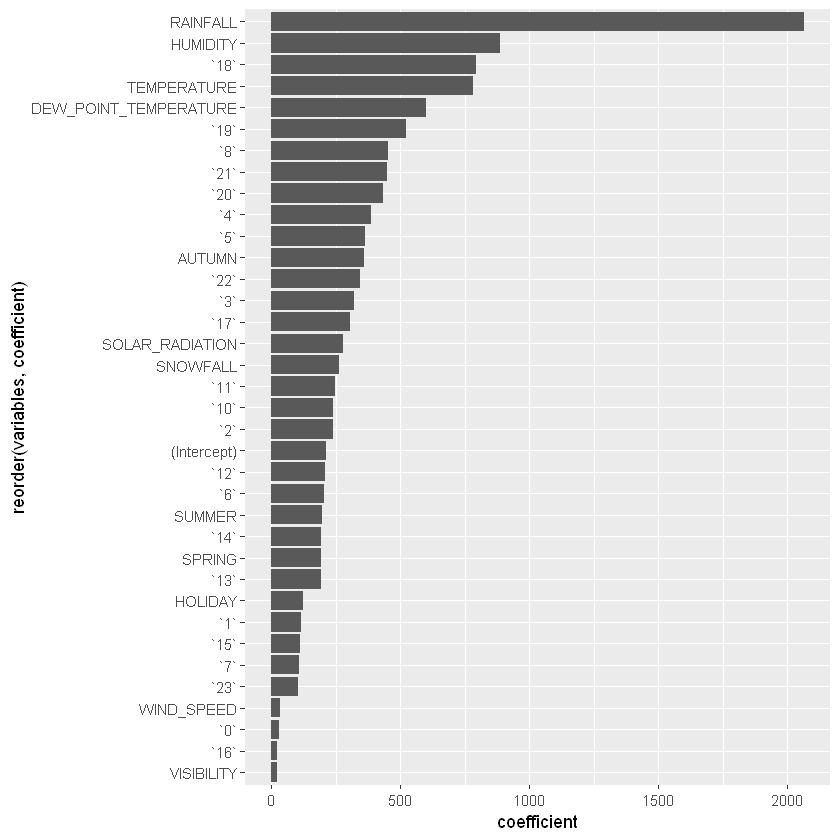

In [19]:
# Visualize the list using ggplot and geom_bar
ggplot(coefficients_df, aes(x = coefficient, y = reorder(variables, coefficient))) +
    geom_col()

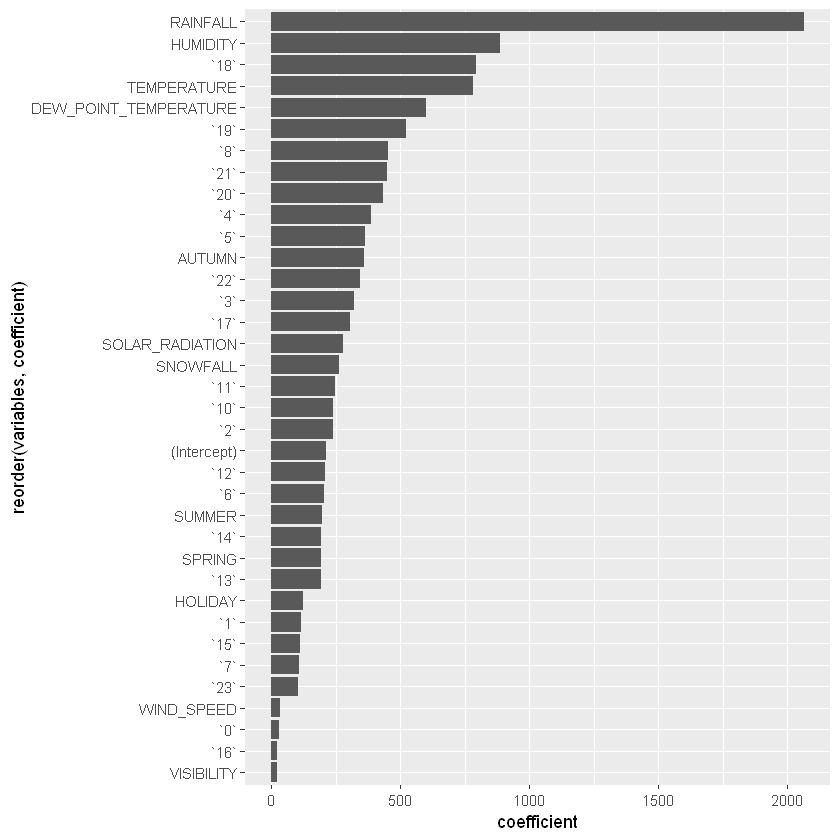

In [20]:
ggplot(coefficients_df, aes(x = coefficient, y = reorder(variables, coefficient))) +
    geom_bar(stat="identity")

The absolute value of the coefficients is used to easily identify important variables (those with large magnitudes regardless of their sign). The top-ranked variables by coefficient will be used subsequently for model refinement.

`RAINFALL`, `HUMIDITY` and `TEMPERATURE` have the highest coefficients.

### Alternative ranking without absolute values

When interpreting the model, it is better to separate the positive and negative coefficients.

In [21]:
# Sort coefficient list
coefficient<-sort(lm_model_all$fit$coefficients, decreasing=TRUE)
coefficients_df <- data.frame(coefficient)

variables <- factor(row.names(coefficients_df))
coefficients_df
variables

,coefficient
,<dbl>
`18`,794.80315
TEMPERATURE,782.65787
DEW_POINT_TEMPERATURE,598.38726
`19`,522.98821
`8`,450.97753
`21`,446.58053
`20`,431.99524
AUTUMN,358.99944
`22`,342.64092


[1] `18`                  TEMPERATURE           DEW_POINT_TEMPERATURE
 [4] `19`                  `8`                   `21`                 
 [7] `20`                  AUTUMN                `22`                 
[10] `17`                  SOLAR_RADIATION       SNOWFALL             
[13] (Intercept)           SUMMER                SPRING               
[16] `7`                   `23`                  WIND_SPEED           
[19] `16`                  VISIBILITY            `0`                  
[22] `15`                  `1`                   HOLIDAY              
[25] `13`                  `14`                  `6`                  
[28] `12`                  `2`                   `10`                 
[31] `11`                  `3`                   `5`                  
[34] `4`                   HUMIDITY              RAINFALL             
36 Levels: (Intercept) `0` `1` `10` `11` `12` `13` `14` `15` `16` `17` ... WIND_SPEED

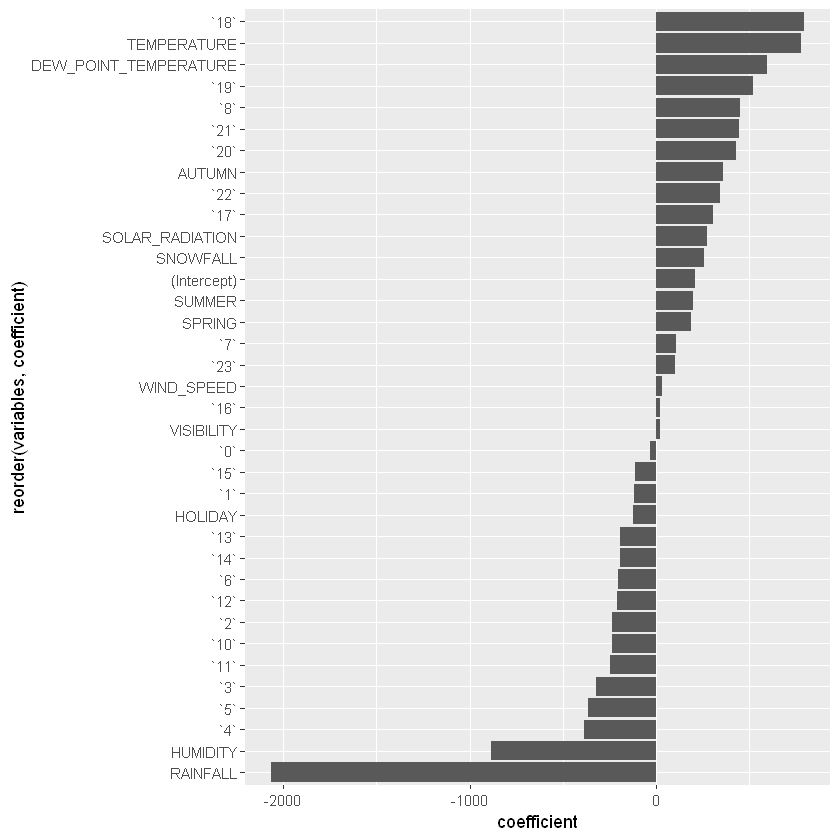

In [22]:
ggplot(coefficients_df, aes(x = coefficient, y = reorder(variables, coefficient))) +
    geom_col()

- `TEMPERATURE` and `DEW_POINT_TEMPERATURE` seem to predict increased bike demand.
- `HUMIDITY` and `RAINFALL` seem to predict reduced bike demand.